<a href="https://colab.research.google.com/github/kratiagrawal100/SMAI_Team_30/blob/main/domain_adaptation_MNIST_SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>MNIST SVHN Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://github.com/arthurdouillard/deepcourse/issues).

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. I strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

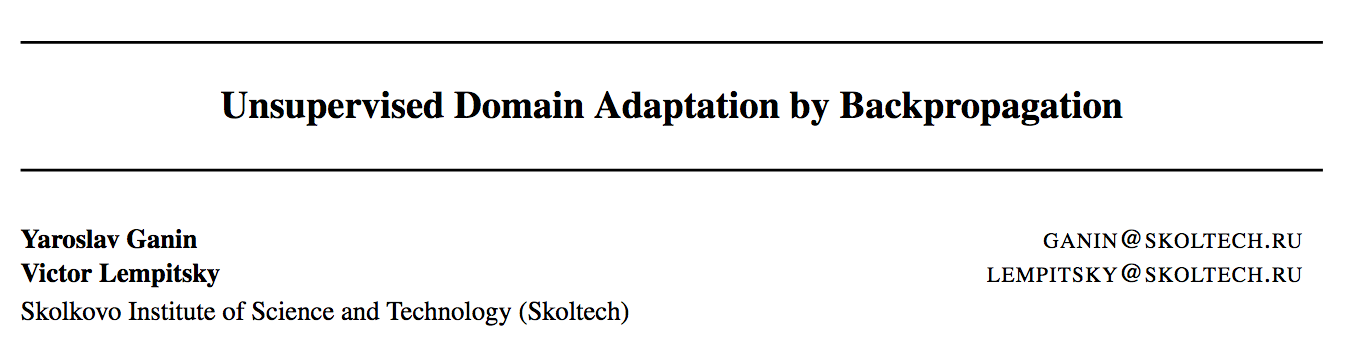

In [127]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['mean', 'beta', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [128]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [129]:
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/mnistm.py
from mnistm import create_mnistm

create_mnistm()

--2023-05-06 11:07:42--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2659 (2.6K) [text/plain]
Saving to: ‘mnistm.py.1’

mnistm.py.1         100%[===================>]   2.60K  --.-KB/s    in 0s      

2023-05-06 11:07:42 (33.1 MB/s) - ‘mnistm.py.1’ saved [2659/2659]



In [130]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/siamese/backbone.py
# %pycat backbone.py

Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [131]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [132]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

In [133]:
len(mnist_train)
len(mnist_test)

10000

In [134]:
dataiter = iter(source_train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([128, 3, 28, 28])


... and visualize!

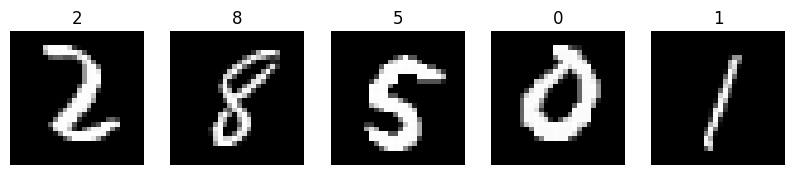

In [135]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

In [136]:
svhn_pixels = datasets.SVHN(root='./data', split='train', transform=transform, download=True).data/255
mean2 = svhn_pixels.mean().item()
std2 = svhn_pixels.std().item()
print(f"Mean {mean2} and Std {std2}")
mean2 = torch.tensor([mean2, mean2, mean2])
std2 = torch.tensor([std2, std2, std2])

Using downloaded and verified file: ./data/train_32x32.mat
Mean 0.4514187438009213 and Std 0.19929124669110956


In [137]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean2, std=std2)
])

# Load the training set
svhn_train = datasets.SVHN(root='./data', split='train', transform=transform, download=True)

# Load the test set
svhn_test = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

# Create data loaders for the training and test sets
target_train_loader = torch.utils.data.DataLoader(svhn_train, batch_size=64, shuffle=True)
target_test_loader = torch.utils.data.DataLoader(svhn_test, batch_size=64, shuffle=False)


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [138]:
len(svhn_train)
len(svhn_test)

26032

In [139]:
dataiter2 = iter(target_train_loader)
images, labels = next(dataiter2)
print(images.shape)

torch.Size([64, 3, 28, 28])


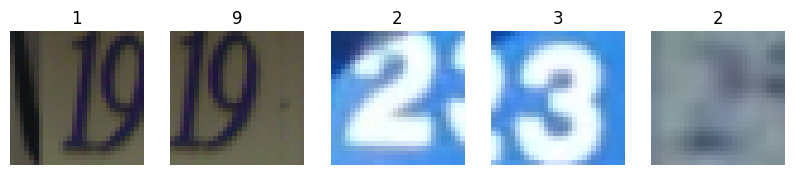

In [140]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = svhn_train[i]
  img = ((x * std2[:, None, None] + mean2[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

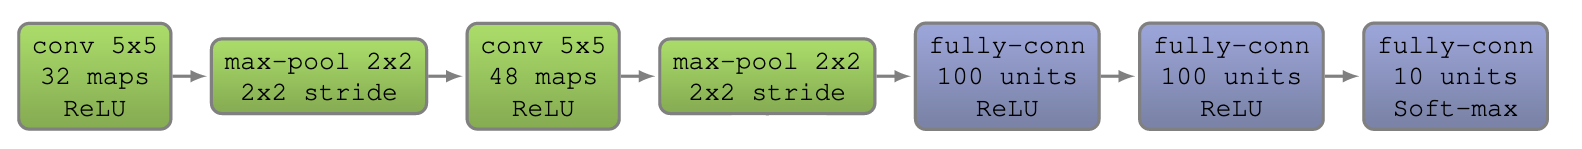

In [141]:
# class NaiveNet(nn.Module):
#   def __init__(self):
#     super().__init__()  # Important, otherwise will throw an error

#     self.cnn = None # TODO

#     self.classif = None # TODO

#   def forward(self, x):
#     # TODO
#     return x
#input image is 28*28*3
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        #28*28*3
        nn.Conv2d(3, 64, kernel_size=5,padding=3),  # 64x30x30
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),  # 64x14x14
        nn.Conv2d(64, 64, kernel_size=5,padding=2),  # 64x14x14
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),  # 64x6x6

        nn.Conv2d(64, 128, kernel_size=5),  # 128x2x2
        nn.ReLU(inplace=True),
    )
    # size= 32*32*3
    # self.cnn = nn.Sequential(
    #     nn.Conv2d(3, 64, kernel_size=5,padding=2),  # 64x28x28
    #     nn.ReLU(inplace=True),
    #     nn.MaxPool2d(kernel_size=3, stride=2),  # 64x13x13
    #     nn.Conv2d(64, 64, kernel_size=5),  # 64x9x9
    #     nn.ReLU(inplace=True),
    #     nn.MaxPool2d(kernel_size=3, stride=2),  # 64x4x4

    #     nn.Conv2d(64, 128, kernel_size=5),  # 128x7x7
    #     nn.ReLU(inplace=True),
    # )

    self.classif = nn.Sequential(
        # nn.Linear(1152, 3072),
        nn.Linear(512, 3072),
        nn.ReLU(inplace=True),
        nn.Linear(3072, 2048),
        nn.ReLU(inplace=True),
        nn.Linear(2048, 10)
    )

  def forward(self, x):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)
    return self.classif(x)


# NaiveNet()(torch.randn(64, 3, 28, 28)).shape

In [142]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/naive.py
# %pycat naive.py

In [143]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification. 

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [145]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=0.001, momentum=0.9)

# mu0, alpha, beta = 0.01, 10, 0.75
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda e: mu0 / (1 + alpha * e / epochs) ** beta
# )

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  # scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 1.36928
	Learning rate = 0.001
Epoch 1, train loss: 0.19815
	Learning rate = 0.001
Epoch 2, train loss: 0.11979
	Learning rate = 0.001
Epoch 3, train loss: 0.08976
	Learning rate = 0.001
Epoch 4, train loss: 0.07319
	Learning rate = 0.001
Epoch 5, train loss: 0.06293
	Learning rate = 0.001
Epoch 6, train loss: 0.05595
	Learning rate = 0.001
Epoch 7, train loss: 0.05089
	Learning rate = 0.001
Epoch 8, train loss: 0.04679
	Learning rate = 0.001
Epoch 9, train loss: 0.04328
	Learning rate = 0.001
Test loss: 0.03332, test acc: 98.86


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [146]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 2.24203, test acc: 28.78


In [147]:
dataiter = iter(target_test_loader)
images, labels = next(dataiter)
print(images.shape)

dataiter = iter(source_train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([64, 3, 28, 28])
torch.Size([128, 3, 28, 28])


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

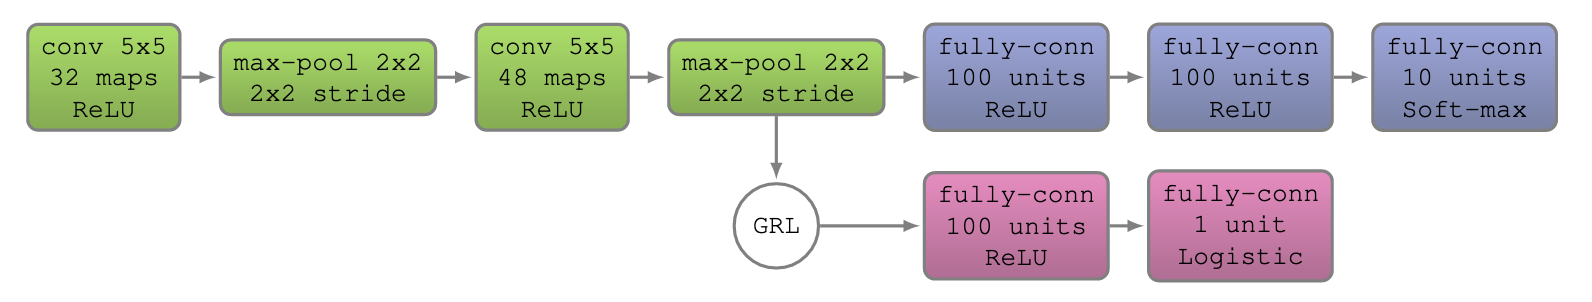

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [148]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/grl.py
# %pycat grl.py

class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    return factor * grad, None


In [149]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply 

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

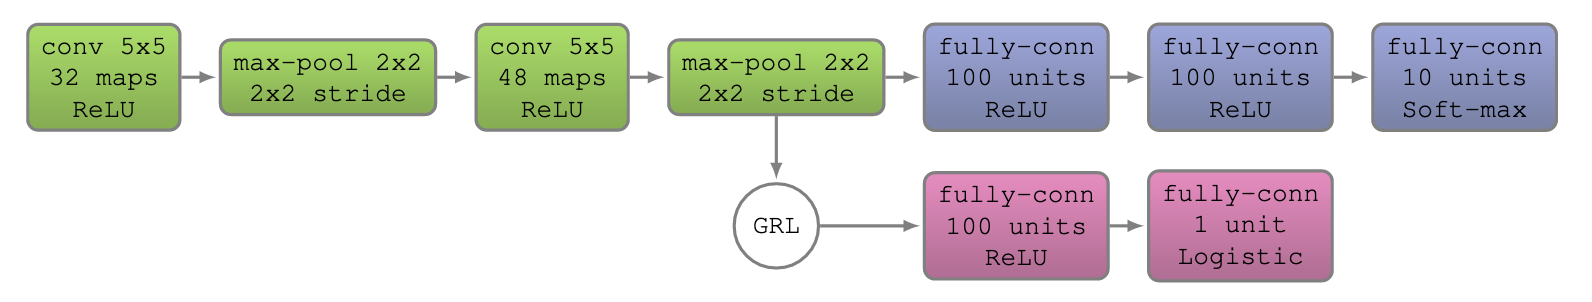

In [ ]:
# class DANN(nn.Module):
#   def __init__(self):
#     super().__init__()  # Important, otherwise will throw an error

#     self.cnn = # TODO

#     self.classif = # TODO

#     self.domain = # TODO

#   def forward(self, x, factor=1):
#     # TODO

#     return class_pred, domain_pred


In [150]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/da/dann.py
# %pycat dann.py

class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    # self.cnn = nn.Sequential(
    #     nn.Conv2d(3, 32, kernel_size=5),  # 32x28x28
    #     nn.ReLU(inplace=True),
    #     nn.MaxPool2d(kernel_size=2, stride=2),  # 32x14x14
    #     nn.Conv2d(32, 48, kernel_size=5),  # 48x14x14
    #     nn.ReLU(inplace=True),
    #     nn.MaxPool2d(kernel_size=2, stride=2),  # 48x7x7
    # )

    # self.classif = nn.Sequential(
    #     nn.Linear(4 * 4 * 48, 100),
    #     nn.ReLU(inplace=True),
    #     nn.Linear(100, 100),
    #     nn.ReLU(inplace=True),
    #     nn.Linear(100, 10)
    # )
    self.cnn = nn.Sequential(
    #28*28*3
    nn.Conv2d(3, 64, kernel_size=5,padding=3),  # 64x30x30
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),  # 64x14x14
    nn.Conv2d(64, 64, kernel_size=5,padding=2),  # 64x14x14
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),  # 64x6x6

    nn.Conv2d(64, 128, kernel_size=5),  # 128x2x2
    nn.ReLU(inplace=True),
)

    self.classif = nn.Sequential(
        # nn.Linear(1152, 3072),
        nn.Linear(512, 3072),
        nn.ReLU(inplace=True),
        nn.Linear(3072, 2048),
        nn.ReLU(inplace=True),
        nn.Linear(2048, 10)
    )

    self.domain = nn.Sequential(
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1)
    )

    self.grl = GradientReversal.apply

  def forward(self, x, factor=1):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)

    class_pred = self.classif(x)
    domain_pred = self.domain(self.grl(x, -1 * factor))

    return class_pred, domain_pred


In [151]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((domain_logits[:, 0] > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

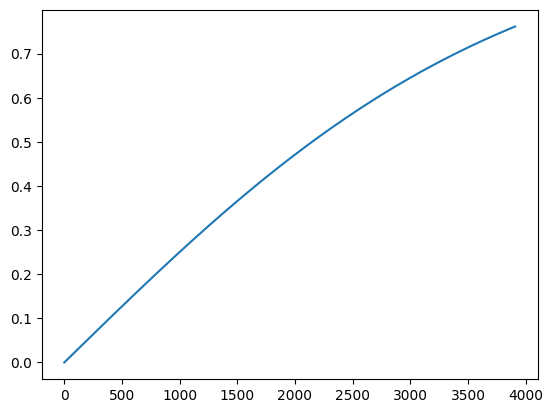

In [152]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


In [ ]:
# data,label=next(iter(source_train_loader))
# print(data.shape)

Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [153]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=0.001, momentum=0.9)

# mu0, alpha, beta = 0.01, 10, 0.75
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
# )
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  # grl_factor = 10
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    # grl_factor = 10
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = F.cross_entropy(cls_logits[:len(ys)], ys)

    bce = F.binary_cross_entropy_with_logits(
        domain_logits[:, 0],
        torch.cat((
            torch.ones(len(xs)),
            torch.zeros(len(xt))
        )).cuda()
    )
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 7)
  domain_loss = round(domain_loss / len(source_train_loader),7 )
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  # scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 1.3017587, domain loss: 0.3632126
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.1989818, domain loss: 0.1421783
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.1244197, domain loss: 0.1445358
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.0973602, domain loss: 0.0840409
GRL factor 0.197375320224904
Epoch 4, class loss: 0.079345, domain loss: 0.080495
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.0711066, domain loss: 0.0587375
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.0645972, domain loss: 0.0777376
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.0607848, domain loss: 0.0722497
GRL factor 0.379948962255225
Epoch 8, class loss: 0.0571849, domain loss: 0.0722633
GRL factor 0.4218990052500078
Epoch 9, class loss: 1.4220887, domain loss: 0.6775037
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.1246483, domain loss: 0.1906206
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.118695, domain loss: 0.324

In [154]:
class_acc,domain_acc,class_loss,domain_loss = eval_dann(dann, target_test_loader)
print(f"class acc: {class_acc}, domain acc: {domain_acc},class loss: {class_loss},domain loss: {domain_loss}")

class acc: 16.58, domain acc: 0.52,class loss: 8.75592,domain loss: 1.49398


## Target Only Training


In [156]:
epochs = 10

naive_net_target = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net_target.parameters(), lr=0.001, momentum=0.9)

# mu0, alpha, beta = 0.01, 10, 0.75
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
# )

for epoch in range(epochs):
  train_loss = 0.

  for x, y in target_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net_target(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(target_train_loader), 5)}')
  # scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr' ]}")

test_acc, test_loss = eval_model(naive_net_target, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 2.21423
	Learning rate = 0.001
Epoch 1, train loss: 1.29492
	Learning rate = 0.001
Epoch 2, train loss: 0.61737
	Learning rate = 0.001
Epoch 3, train loss: 0.47879
	Learning rate = 0.001
Epoch 4, train loss: 0.40422
	Learning rate = 0.001
Epoch 5, train loss: 0.35597
	Learning rate = 0.001
Epoch 6, train loss: 0.32136
	Learning rate = 0.001
Epoch 7, train loss: 0.29571
	Learning rate = 0.001
Epoch 8, train loss: 0.27605
	Learning rate = 0.001
Epoch 9, train loss: 0.2563
	Learning rate = 0.001
Test loss: 0.31071, test acc: 91.06


We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [157]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    # print(x.shape)
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [158]:
from sklearn.manifold import TSNE

50000
Original embeddings of source / target (50000, 512) (73257, 512)
Samples embeddings (2000, 512) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

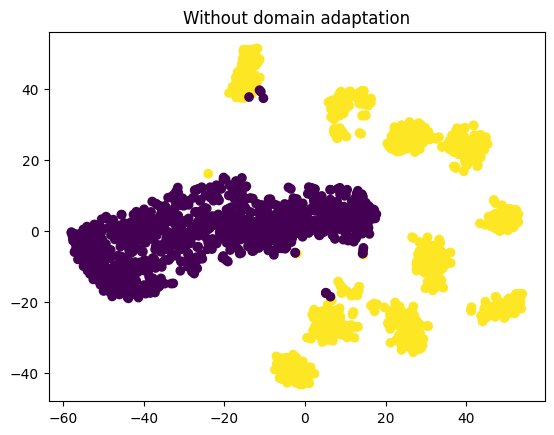

In [159]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)
print(len(source_emb))

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (50000, 512) (73257, 512)
Samples embeddings (2000, 512) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

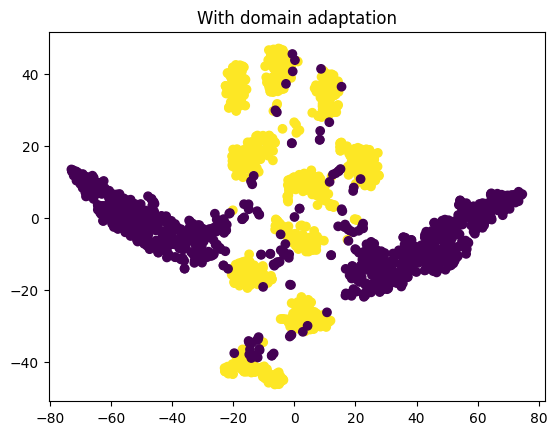

In [160]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

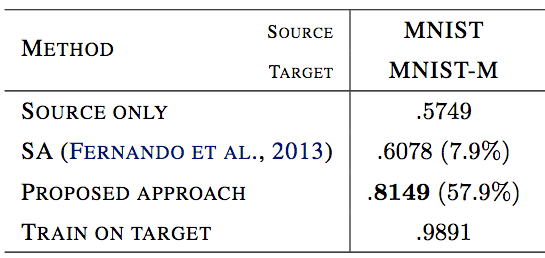

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling